# 5. Reducción dataset

El objetivo de este notebook es procesar el dataset que se ha utilizado para entrenar le modelo preliminar y tratar de reducir la dimensionalidad de este sin perder precisión. De esta forma, se identificarán que sensores no son necesarios en la máquina para identificar posibles reducciones de costes.

## 5.1. Dataset y modelo inicial

In [25]:
import pandas as pd

In [26]:
df = pd.read_csv("processed_data_ultimate.csv")
print("El dataset tiene incialmente un tamaño de:")
df.shape

El dataset tiene incialmente un tamaño de:


(84000, 67)

Antes de comenzar la reducción de dimensionalidad del dataset, el modelo de Random Forest tiene una precisión de:


Accuracy (test con 'medida' = 6g, '1.5mm', '1.40mm'): 0.98
Matriz de Confusión:
[[ 7196     3   344   193   154   110]
 [    0 13955    36     0     0     9]
 [    0     0  2000     0     0     0]
 [   29    68   114 23687    70    32]
 [    6     0     8   177 23764    45]
 [    5     1     0     4     0 11990]]
Reporte de Clasificación:
                         precision    recall  f1-score   support

horizontal-misalignment       0.99      0.90      0.94      8000
              imbalance       0.99      1.00      1.00     14000
                 normal       0.80      1.00      0.89      2000
               overhang       0.98      0.99      0.99     24000
              underhang       0.99      0.99      0.99     24000
  vertical-misalignment       0.98      1.00      0.99     12000

               accuracy                           0.98     84000
              macro avg       0.96      0.98      0.97     84000
           weighted avg       0.98      0.98      0.98     84000



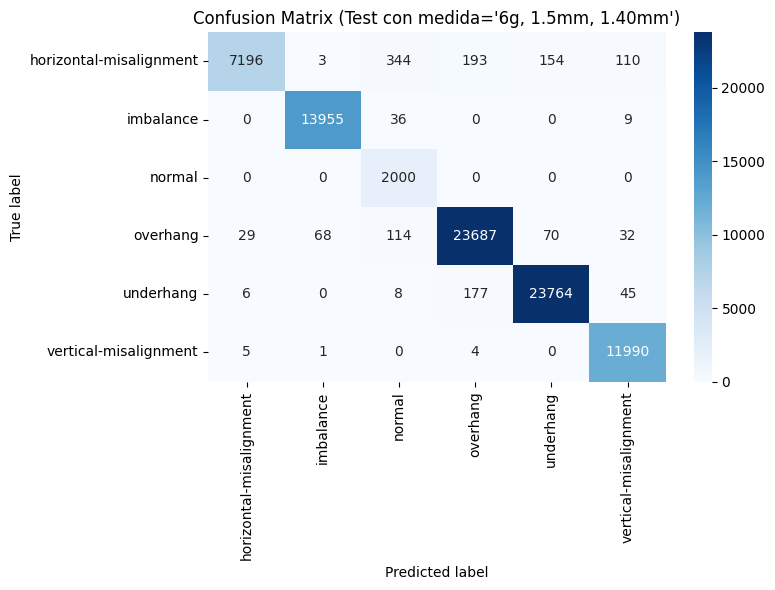

In [27]:
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

# Cargar el dataset
df = pd.read_csv("ultimate.csv")

# Selección de carpetas para entrenamiento y prueba
df_train = df[(df["medida"] != "6g") & (df["medida"] != "1.5mm") & (df["medida"] != "1.40mm") & (df["medida"] != 0)]  # Para entrenar
df_test  = df[(df["medida"] == "6g") | (df["medida"] == "1.5mm") | (df["medida"] == "1.40mm") | (df["medida"] != 0)]  # Para probar

# Separar características y etiquetas
X_train = df_train.drop(columns=["Hz", "medida", "Tipo"])
y_train = df_train["Tipo"]

X_test = df_test.drop(columns=["Hz", "medida", "Tipo"])
y_test = df_test["Tipo"]

# Entrenar el modelo
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Predecir en el conjunto de prueba
y_pred = model.predict(X_test)

# Calcular métricas
acc = accuracy_score(y_test, y_pred)
cm = confusion_matrix(y_test, y_pred)
report = classification_report(y_test, y_pred)

print(f"Accuracy (test con 'medida' = 6g, '1.5mm', '1.40mm'): {acc:.2f}")
print("Matriz de Confusión:")
print(cm)
print("Reporte de Clasificación:")
print(report)

# Obtener todas las clases conocidas por el modelo
labels = sorted(model.classes_)  # Asegura incluir todas las clases del modelo

# Graficar la matriz de confusión
plt.figure(figsize=(8, 6))
sns.heatmap(
    cm, 
    annot=True,
    fmt='d', 
    cmap='Blues',
    xticklabels=labels,
    yticklabels=labels
)
plt.xlabel("Predicted label")
plt.ylabel("True label")
plt.title("Confusion Matrix (Test con medida='6g, 1.5mm, 1.40mm')")
plt.tight_layout()
plt.show()


## 5.2. Filtrado inicial
Reducción de dimensionalidad no supervisada
### 5.2.1. Eliminar variables de baja varianza
Algunas variables pueden presentar muy poca variación (casi todos los valores iguales), lo que las hace poco relevantes para la predicción.

In [40]:
from sklearn.feature_selection import VarianceThreshold

numerical_features = df.select_dtypes(include=['int64', 'float64'])
numerical_features = numerical_features.drop("Hz",axis=1)
print("Dimensiones iniciales:")
print(numerical_features.shape)

selector = VarianceThreshold() # threshold=0 elimina solo las de varianza 0
df_reduced1 = selector.fit_transform(numerical_features)
print("Dimensiones procesadas")
print(df_reduced1.shape)

print("No hay reducción por tanto no hay variables que presenten sin variación")


Dimensiones iniciales:
(84000, 64)
Dimensiones procesadas
(84000, 64)
No hay reducción por tanto no hay variables que presenten sin variación


### 5.2.2. Análisis de correlación
Si hay varaibles altamente correlacionadas entre sí (multicolinealidad), puede bastar con quedarte con una de ellas.

In [44]:
import pandas as pd
import numpy as np

print("Dimensiones previas:")
print(df_reduced1.shape)

correl_matrix = df_reduced1.corr().abs()

# Se queda con la parte triangular superior (para no duplicar)
upper_tri = correl_matrix.where(np.triu(np.ones(correl_matrix.shape), k=1).astype(bool))

# Encuentra columnas con correlación superior a 0.9
to_drop = [column for column in upper_tri.columns if any(upper_tri[column] > 0.9)]
print("Columnas que se han eliminado por alta correlación:", to_drop)
df_reduced2 = df_reduced1.drop(columns=to_drop)

print("Dimensiones procesadas:")
print(df_reduced2.shape)

Dimensiones previas:
(84000, 64)
Columnas que se han eliminado por alta correlación: ['col_3', 'col_6', 'col_11', 'col_13', 'col_14', 'col_15', 'col_17', 'col_21', 'col_22', 'col_23', 'col_27', 'col_29', 'col_30', 'col_31', 'col_33', 'col_35', 'col_39', 'col_41', 'col_43', 'col_45', 'col_46', 'col_47', 'col_49', 'col_51', 'col_53', 'col_54', 'col_55', 'col_59', 'col_61']
Dimensiones procesadas:
(84000, 35)


## 5.3. Métodos supervisados de selección de características
Estos métodos consideran la relación entre cada variable y la variable objetivo ("Tipo") para descartar características irrelevantes o redundantes.

### 5.3.1. Feature importance en modelos basados en árboles
* Entrenar un Random Forest o un XGBoost preliminarmente y obtener la importancia de cada variable.
* Con la importancia, filtrar aquellaspor debajo un cierto umbral o seleccionar las "top K" variables más relevantes.

In [48]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from xgboost import XGBClassifier

le = LabelEncoder()
y_train_encoded = le.fit_transform(y_train)
y_test_encoded = le.transform(y_test)   # para test, usar "transform", NO "fit_transform"

model = XGBClassifier()
model.fit(X_train, y_train_encoded)

y_pred_encoded = model.predict(X_test)

y_pred = le.inverse_transform(y_pred_encoded) # Descodificar para obtener los nombres originales

from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

print("\nAccuracy:", accuracy_score(y_test, y_pred))
print("Matriz de Confusión:\n", confusion_matrix(y_test, y_pred))
print("Reporte de Clasificación:\n", classification_report(y_test, y_pred))



Accuracy: 0.9845119047619048
Matriz de Confusión:
 [[ 7392    11   293   145    62    97]
 [   16 13829   129     0     0    26]
 [    0     0  2000     0     0     0]
 [   14    74   153 23624   102    33]
 [    8     0     6    94 23862    30]
 [    4     1     0     3     0 11992]]
Reporte de Clasificación:
                          precision    recall  f1-score   support

horizontal-misalignment       0.99      0.92      0.96      8000
              imbalance       0.99      0.99      0.99     14000
                 normal       0.77      1.00      0.87      2000
               overhang       0.99      0.98      0.99     24000
              underhang       0.99      0.99      0.99     24000
  vertical-misalignment       0.98      1.00      0.99     12000

               accuracy                           0.98     84000
              macro avg       0.96      0.98      0.97     84000
           weighted avg       0.99      0.98      0.98     84000



### 5.3.2. Selección por modelos lineales con regularización L1 (Lasso)
* Aplicar un modelo lineal (por ejemplo, Logistic Regression con penalización L1) que fuerce a ciertos coeficientes a ser cero y elimina variables poco relevantes.

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import SelectFromModel

estimator = LogisticRegression(penalty='l1', solver='saga', max_iter=2000)
selector = SelectFromModel(estimator=estimator, threshold='mean')
selector.fit(X_train, y_train)

X_train_reduced = selector.transform(X_train)
X_test_reduced  = selector.transform(X_test)